In [77]:
# keras supplied image generator
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2DTranspose, UpSampling2D, Reshape
from keras.optimizers import RMSprop
from IPython.display import Image, display
from itertools import repeat
import PIL as PIL

import numpy as np

#the size for both the real and the fake data
partial_batch_size = 16
scale = 

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

read_data_gen = datagen.flow_from_directory(os.getcwd()+'/training/', target_size=(64,64),batch_size=partial_batch_size)


Found 296 images belonging to 1 classes.


Generator is based off of `UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS` available [here](https://arxiv.org/abs/1511.06434)

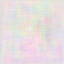

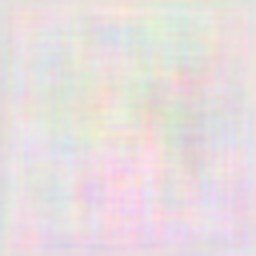

In [79]:
def get_generator():
    m = Sequential()
    m.add(Dense((4*4*1024), input_shape=(100,), activation = 'relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Reshape((4,4,1024)))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(512,8, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(256,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(128,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(UpSampling2D())
    m.add(Conv2DTranspose(64,5, activation = 'relu', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    m.add(Conv2DTranspose(3,5, activation = 'sigmoid', padding='same', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    return m


def output_to_image(array):
    array = array*127.5+127.5
    i = array_to_img(array).resize((64,64)*4, PIL.Image.ANTIALIAS)
    return i

generator_model = get_generator()
generator_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
#generator_model.summary()


sample_in = np.zeros((1, 100))
sample_in[1:] = np.random.uniform(-1, 1, 100)
sample_out = generator_model.predict(sample_in)[0]

display(array_to_img(sample_out*127.5+127.5))
display(output_to_image(sample_out))